# Classify images according to isCancerous
In this notebook the goal is to classify the images according to their isCancerous state (0 or 1)

# Setup
1. Import libraries
2. Setting up data sets
3. Initialize learning curve function

We will also concatenate data_labels_mainData.csv and data_labels_extraData.csv together for this model as both contains data for the column isCancerous.

In [208]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd
import seaborn as sn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_recall_fscore_support

tf.__version__

'2.5.0'

In [209]:
from sklearn.model_selection import train_test_split


data1 = pd.read_csv('./data_labels_mainData.csv')
data2 = pd.read_csv('./data_labels_extraData.csv')

data1.head()

InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0       22405          1  22405.png   fibroblast         0            0
1       22406          1  22406.png   fibroblast         0            0
2       22407          1  22407.png   fibroblast         0            0
3       22408          1  22408.png   fibroblast         0            0
4       22409          1  22409.png   fibroblast         0            0

In [210]:
data2.head()

InstanceID  patientID  ImageName  isCancerous
0       12681         61  12681.png            0
1       12682         61  12682.png            0
2       12683         61  12683.png            0
3       12684         61  12684.png            0
4       12685         61  12685.png            0

In [211]:
data1_edited = data1.drop(columns=['cellTypeName', 'cellType'])

In [212]:
concatenated_dataframe = pd.concat([data1_edited, data2])

In [213]:
print(data1.shape)
print(data2.shape)
print(concatenated_dataframe.shape)

(9896, 6)
(10384, 4)
(20280, 4)


In [214]:
data = concatenated_dataframe
train_data_big, test_data_big = train_test_split(concatenated_dataframe, test_size=0.2, random_state=42)
train_data_big, val_data_big = train_test_split(train_data_big, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data_big.shape[0], val_data_big.shape[0], test_data_big.shape[0]))

Train data : 12168, Val Data: 4056, Test Data: 4056


In [215]:
from sklearn.model_selection import train_test_split

_, train_data = train_test_split(train_data_big, test_size=0.3, random_state=42)
_, test_data = train_test_split(test_data_big, test_size=0.3, random_state=42)
_, val_data = train_test_split(val_data_big, test_size=0.3, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 3651, Val Data: 1217, Test Data: 1217


# EDA

In [216]:
data1.cellTypeName.unique()

array(['fibroblast', 'inflammatory', 'others', 'epithelial'], dtype=object)

Since there is 4 cell type and 2 isCancerous type, the number of label that one model has to predict is 8. It is better to have 4 models and each model handling 1 cell type and 2 isCancerous type and predict 2 label than having one model predict 8. 

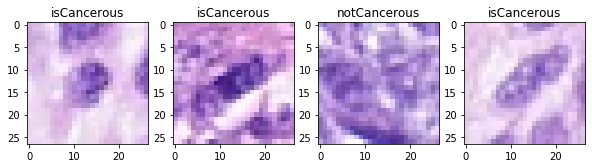

In [217]:
from PIL import Image

label_names = {'isCancerous' : 0, 'notCancerous' : 1}
d_inv = {v: k for k, v in label_names.items()}

img_list = list('./patch_images/'+train_data['ImageName'])
target = train_data['isCancerous']
target_list = list(target)

fig = plt.figure(figsize=[10,10])

for i in np.arange(4):
    plt.subplot(1, 4, i+1)
    img = Image.open(img_list[i])
    
    plt.imshow(img)
    plt.title(d_inv[int(target_list[i])])

In [218]:
# check image size
img = Image.open(img_list[10])
img_numpy = np.ascontiguousarray(img, dtype=np.float32)
print('Image size \nH:{} W:{} C:{}'.format(img_numpy.shape[0], img_numpy.shape[1], img_numpy.shape[2]))

Image size 
H:27 W:27 C:3


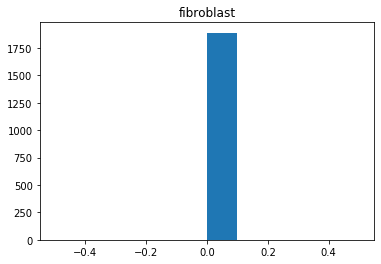

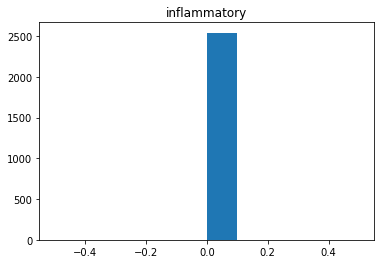

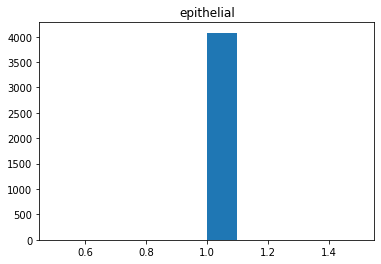

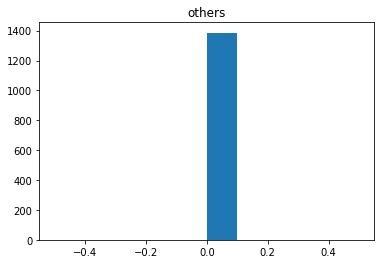

In [219]:
fibroblast = data1[data1['cellType']==0]
inflammatory = data1[data1['cellType']==1]
epithelial = data1[data1['cellType']==2]
others = data1[data1['cellType']==3]


plt.hist(fibroblast['isCancerous'])
plt.title('fibroblast')
plt.show()

plt.hist(inflammatory['isCancerous'])
plt.title('inflammatory')
plt.show()

plt.hist(epithelial['isCancerous'])
plt.title('epithelial')
plt.show()

plt.hist(others['isCancerous'])
plt.title('others')
plt.show()

Observation: An interesting revalation occur, apparently cell type fibroblast, inflammatory and other does not have isCancerous lable while cell type epithelial does not have notCancerous label. 

From the observation above, it would not be smart to have 4 models handling each type of cell. Sorry if this contracdict with what I said above but I tried to avoid a "Zero Frequency Probem"

## Further setups

In [220]:
# learning curve function
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()
    
# cellType needs to be string
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\PC\anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [221]:
# initializing data generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 3651 validated image filenames belonging to 2 classes.
Found 1217 validated image filenames belonging to 2 classes.
Found 1217 validated image filenames belonging to 2 classes.


# Performace evaluation tool

In [222]:
def PredictModel(model):
    batch_size_ = 1
    y_pred = list()
    y_test = list()
    filenames = test_generator.filenames
    N_images = len(filenames)
    batches = 0

    # iterate through the data generator and predict for each batch
    # hold the predictions and labels
    for x,y in test_generator:
            yp = model.predict(x, verbose=0)
            yp = np.argmax(yp, axis = 1)
            yt = np.argmax(y, axis = 1)
            y_pred = y_pred + yp.tolist()
            y_test = y_test + yt.tolist()

            batches += 1
            if batches >= N_images / batch_size_:
                break
                
    return (y_test, y_pred)

In [223]:
def PlotConfusionMatrix(test, pred):
    cm = confusion_matrix(test, pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sn.heatmap(cm, annot=labels, fmt='', cmap='Blues')

In [224]:
class ModelResult:
    def __init__(self, name, accuracy, f1, precision, recall):
        self.name = name
        self.accuracy = accuracy
        self.f1 = f1
        self.precision = precision
        self.recall = recall
    
modelResults = list()

In [225]:
def ShowStats(test_name, y_test, y_pred):
    accuracy = accuracy_score(test_y, pred_y)
    f1 = f1_score(test_y, pred_y, average='macro')
    cm = classification_report(test_y, pred_y, zero_division=0)
    
    prfs = precision_recall_fscore_support(test_y, pred_y, zero_division=0)
    detect_precision = prfs[0][1]
    detect_recall = prfs[1][1]

    mr = ModelResult(test_name, accuracy, f1, detect_precision, detect_recall)
    modelResults.append(mr)

    print("Accuracy score: ", accuracy_score(test_y, pred_y))
    print("F1 score: ", f1_score(test_y, pred_y, average='macro'))
    print(classification_report(test_y, pred_y, zero_division=0))

# 1) NN model as Base model
We will use a simple NN model using Keras Sequential for our base model

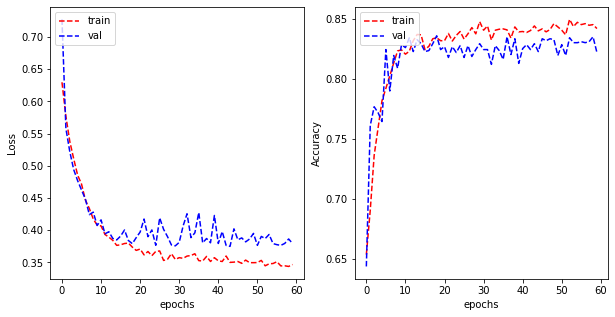

In [227]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 2

model_cancer = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

model_cancer.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history = model_cancer.fit(train_generator, validation_data = validation_generator, epochs=60, verbose=0)

plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Parameters Tuning for base model
### Regularization
Tuning the lambda value for l2 regulurization

In [228]:
reg_lambda = 0.02

model_cancer_reg = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

model_cancer_reg.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history_cancer_reg = model_cancer_reg.fit(train_generator, validation_data = validation_generator, epochs=60, verbose=0)

plot_learning_curve(history_cancer_reg.history['loss'], history_cancer_reg.history['val_loss'], 
                    history_cancer_reg.history['categorical_accuracy'], history_cancer_reg.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### Drop out
Next we try to add a dropout layer to regularize the model

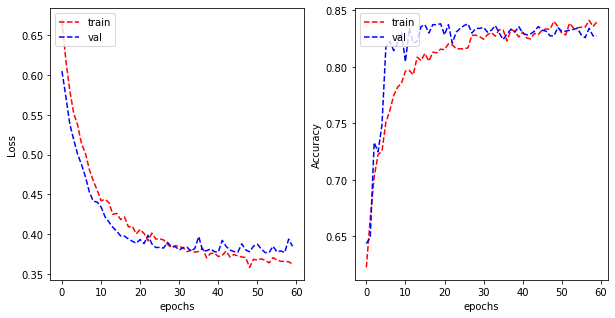

In [229]:
model_cancer_drop = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dropout(.3),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

model_cancer_drop.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history_cancer_drop = model_cancer_drop.fit(train_generator, validation_data = validation_generator, epochs=60, verbose=0)

plot_learning_curve(history_cancer_drop.history['loss'], history_cancer_drop.history['val_loss'], 
                    history_cancer_drop.history['categorical_accuracy'], history_cancer_drop.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Cross validation to train the model

In [230]:
from sklearn.model_selection import KFold, StratifiedKFold

Y = train_data[['isCancerous']]
kf = KFold(n_splits = 5)
Y

isCancerous
6301           0
8117           0
1804           1
6017           0
8430           0
...          ...
1283           1
4912           0
2612           1
4436           0
1703           0

[3651 rows x 1 columns]

In [231]:
idg = ImageDataGenerator(rescale=1./255, data_format='channels_last')

def get_model_name(k):
    return 'model_'+str(k)+'.h5'

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

save_dir = '/cancer_CV/'
fold_var = 1
reg_lambda = 0.02

for train_index, val_index in kf.split(Y):
    training_data = train_data.iloc[train_index]
    validation_data = train_data.iloc[val_index]
    
    train_datagen = idg.flow_from_dataframe(dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')
    valid_datagen  = idg.flow_from_dataframe(dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')
       


    # CREATE NEW MODEL
    model_cancer_CV = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Dense(OUTPUT_CLASSES, kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])
    # COMPILE NEW MODEL
    model_cancer_CV.compile(optimizer='SGD',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])


    # CREATE CALLBACKS
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
                                                    monitor='val_accuracy', verbose=1, 
                                                    save_best_only=True, mode='max')
    callbacks_list = [checkpoint]
    # There can be other callbacks, but just showing one because it involves the model name
    # This saves the best model
    # FIT THE MODEL
    history_CV = model_cancer_CV.fit(train_datagen,
                epochs=60,
                callbacks=callbacks_list,
                validation_data= valid_datagen,
                verbose=1)
    #PLOT HISTORY
    #       :
    #       :

    # LOAD BEST MODEL to evaluate the performance of the model
   
    model_cancer_CV.load_weights("/cancer_CV/model_"+str(fold_var)+".h5")

    results = model_cancer_CV.evaluate(valid_datagen)
    results = dict(zip(model_cancer_CV.metrics_names,results))

    VALIDATION_ACCURACY.append(results['categorical_accuracy'])
    VALIDATION_LOSS.append(results['loss'])

    tf.keras.backend.clear_session()

    fold_var += 1



Found 3651 validated image filenames belonging to 2 classes.
Found 1217 validated image filenames belonging to 2 classes.
Epoch 1/60
115/115 [==============================] - 2s 17ms/step - loss: 9.4466 - categorical_accuracy: 0.6568 - val_loss: 9.0268 - val_categorical_accuracy: 0.6434
Epoch 2/60
115/115 [==============================] - 2s 16ms/step - loss: 8.6295 - categorical_accuracy: 0.6817 - val_loss: 8.2436 - val_categorical_accuracy: 0.6705
Epoch 3/60
115/115 [==============================] - 2s 16ms/step - loss: 7.8974 - categorical_accuracy: 0.7160 - val_loss: 7.5508 - val_categorical_accuracy: 0.7001
Epoch 4/60
115/115 [==============================] - 2s 16ms/step - loss: 7.2333 - categorical_accuracy: 0.7551 - val_loss: 6.9203 - val_categorical_accuracy: 0.7707
Epoch 5/60
115/115 [==============================] - 2s 16ms/step - loss: 6.6339 - categorical_accuracy: 0.7560 - val_loss: 6.3555 - val_categorical_accuracy: 0.8143
Epoch 6/60
115/115 [=======================

Epoch 5/60
115/115 [==============================] - 2s 16ms/step - loss: 6.6460 - categorical_accuracy: 0.7560 - val_loss: 6.3632 - val_categorical_accuracy: 0.7379
Epoch 6/60
115/115 [==============================] - 2s 16ms/step - loss: 6.1000 - categorical_accuracy: 0.7707 - val_loss: 5.8449 - val_categorical_accuracy: 0.7477
Epoch 7/60
115/115 [==============================] - 2s 16ms/step - loss: 5.6049 - categorical_accuracy: 0.7828 - val_loss: 5.3672 - val_categorical_accuracy: 0.8127
Epoch 8/60
115/115 [==============================] - 2s 16ms/step - loss: 5.1483 - categorical_accuracy: 0.7916 - val_loss: 4.9520 - val_categorical_accuracy: 0.8283
Epoch 9/60
115/115 [==============================] - 2s 16ms/step - loss: 4.7403 - categorical_accuracy: 0.7995 - val_loss: 4.5581 - val_categorical_accuracy: 0.8291
Epoch 10/60
115/115 [==============================] - 2s 16ms/step - loss: 4.3627 - categorical_accuracy: 0.8053 - val_loss: 4.1898 - val_categorical_accuracy: 0.81

Epoch 38/60
115/115 [==============================] - 2s 17ms/step - loss: 0.8038 - categorical_accuracy: 0.8242 - val_loss: 0.7943 - val_categorical_accuracy: 0.8340
Epoch 39/60
115/115 [==============================] - 2s 16ms/step - loss: 0.7721 - categorical_accuracy: 0.8302 - val_loss: 0.7731 - val_categorical_accuracy: 0.8373
Epoch 40/60
115/115 [==============================] - 2s 16ms/step - loss: 0.7503 - categorical_accuracy: 0.8299 - val_loss: 0.7506 - val_categorical_accuracy: 0.8373
Epoch 41/60
115/115 [==============================] - 2s 16ms/step - loss: 0.7322 - categorical_accuracy: 0.8263 - val_loss: 0.7412 - val_categorical_accuracy: 0.8110
Epoch 42/60
115/115 [==============================] - 2s 16ms/step - loss: 0.7112 - categorical_accuracy: 0.8272 - val_loss: 0.7141 - val_categorical_accuracy: 0.8348
Epoch 43/60
115/115 [==============================] - 2s 16ms/step - loss: 0.6974 - categorical_accuracy: 0.8277 - val_loss: 0.6928 - val_categorical_accuracy:

Epoch 10/60
115/115 [==============================] - 2s 16ms/step - loss: 4.3645 - categorical_accuracy: 0.8055 - val_loss: 4.1872 - val_categorical_accuracy: 0.8151
Epoch 11/60
115/115 [==============================] - 2s 16ms/step - loss: 4.0216 - categorical_accuracy: 0.8053 - val_loss: 3.8621 - val_categorical_accuracy: 0.8159
Epoch 12/60
115/115 [==============================] - 2s 16ms/step - loss: 3.7107 - categorical_accuracy: 0.8094 - val_loss: 3.5684 - val_categorical_accuracy: 0.8307
Epoch 13/60
115/115 [==============================] - 2s 16ms/step - loss: 3.4300 - categorical_accuracy: 0.8094 - val_loss: 3.2977 - val_categorical_accuracy: 0.8291
Epoch 14/60
115/115 [==============================] - 2s 16ms/step - loss: 3.1732 - categorical_accuracy: 0.8121 - val_loss: 3.0534 - val_categorical_accuracy: 0.8307
Epoch 15/60
115/115 [==============================] - 2s 16ms/step - loss: 2.9358 - categorical_accuracy: 0.8192 - val_loss: 2.8449 - val_categorical_accuracy:

Epoch 14/60
115/115 [==============================] - 2s 16ms/step - loss: 3.1821 - categorical_accuracy: 0.8099 - val_loss: 3.0754 - val_categorical_accuracy: 0.7765
Epoch 15/60
115/115 [==============================] - 2s 16ms/step - loss: 2.9415 - categorical_accuracy: 0.8168 - val_loss: 2.8481 - val_categorical_accuracy: 0.7905
Epoch 16/60
115/115 [==============================] - 2s 16ms/step - loss: 2.7323 - categorical_accuracy: 0.8102 - val_loss: 2.6301 - val_categorical_accuracy: 0.8258
Epoch 17/60
115/115 [==============================] - 2s 16ms/step - loss: 2.5310 - categorical_accuracy: 0.8211 - val_loss: 2.4449 - val_categorical_accuracy: 0.8365
Epoch 18/60
115/115 [==============================] - 2s 16ms/step - loss: 2.3518 - categorical_accuracy: 0.8250 - val_loss: 2.2757 - val_categorical_accuracy: 0.8184
Epoch 19/60
115/115 [==============================] - 2s 16ms/step - loss: 2.1912 - categorical_accuracy: 0.8203 - val_loss: 2.1280 - val_categorical_accuracy:

Epoch 47/60
115/115 [==============================] - 2s 16ms/step - loss: 0.6336 - categorical_accuracy: 0.8296 - val_loss: 0.6445 - val_categorical_accuracy: 0.8184
Epoch 48/60
115/115 [==============================] - 2s 16ms/step - loss: 0.6241 - categorical_accuracy: 0.8283 - val_loss: 0.6335 - val_categorical_accuracy: 0.8184
Epoch 49/60
115/115 [==============================] - 2s 16ms/step - loss: 0.6136 - categorical_accuracy: 0.8277 - val_loss: 0.6246 - val_categorical_accuracy: 0.8192
Epoch 50/60
115/115 [==============================] - 2s 16ms/step - loss: 0.6019 - categorical_accuracy: 0.8302 - val_loss: 0.6387 - val_categorical_accuracy: 0.7880
Epoch 51/60
115/115 [==============================] - 2s 16ms/step - loss: 0.5950 - categorical_accuracy: 0.8291 - val_loss: 0.6106 - val_categorical_accuracy: 0.8291
Epoch 52/60
115/115 [==============================] - 2s 16ms/step - loss: 0.5897 - categorical_accuracy: 0.8354 - val_loss: 0.5933 - val_categorical_accuracy:

Epoch 19/60
115/115 [==============================] - 2s 17ms/step - loss: 2.1911 - categorical_accuracy: 0.8253 - val_loss: 2.1319 - val_categorical_accuracy: 0.8061
Epoch 20/60
115/115 [==============================] - 2s 16ms/step - loss: 2.0414 - categorical_accuracy: 0.8233 - val_loss: 2.0320 - val_categorical_accuracy: 0.7921
Epoch 21/60
115/115 [==============================] - 2s 16ms/step - loss: 1.9108 - categorical_accuracy: 0.8170 - val_loss: 1.8481 - val_categorical_accuracy: 0.8299
Epoch 22/60
115/115 [==============================] - 2s 16ms/step - loss: 1.7834 - categorical_accuracy: 0.8288 - val_loss: 1.7309 - val_categorical_accuracy: 0.8316
Epoch 23/60
115/115 [==============================] - 2s 17ms/step - loss: 1.6732 - categorical_accuracy: 0.8250 - val_loss: 1.6446 - val_categorical_accuracy: 0.7970
Epoch 24/60
115/115 [==============================] - 2s 16ms/step - loss: 1.5669 - categorical_accuracy: 0.8285 - val_loss: 1.5306 - val_categorical_accuracy:

In [233]:
plot_learning_curve(history_CV.history['loss'], history_CV.history['val_loss'], 
                    history_CV.history['categorical_accuracy'], history_CV.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### Save model

In [234]:
# Original model without tuning
model_cancer.save("cancer_base_model")

# Model with regularization
model_cancer_reg.save("cancer_reg_base_model")

# Model with dropout
model_cancer_drop.save("cancer_dropout_base_model")
model_cancer_CV.save("cancer_CV_model")

INFO:tensorflow:Assets written to: cancer_base_model\assets
INFO:tensorflow:Assets written to: cancer_reg_base_model\assets
INFO:tensorflow:Assets written to: cancer_dropout_base_model\assets
INFO:tensorflow:Assets written to: cancer_CV_model\assets


## Testing the final model
The model tuning by dropout seems to have the best performance.

In [235]:
model_cancer.evaluate(test_generator)

39/39 [==============================] - 0s 11ms/step - loss: 0.3467 - categorical_accuracy: 0.8554


[0.3467100262641907, 0.8553820848464966]

In [236]:
(test_y, pred_y) = PredictModel(model_cancer)

In [237]:
ShowStats('base model', test_y, pred_y)


Accuracy score:  0.8553300160598162
F1 score:  0.8411949117338515
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     24620
           1       0.80      0.79      0.79     13363

    accuracy                           0.86     37983
   macro avg       0.84      0.84      0.84     37983
weighted avg       0.86      0.86      0.86     37983



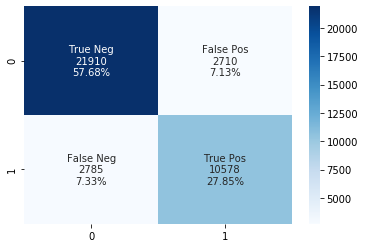

In [238]:
PlotConfusionMatrix(test_y, pred_y)

In [239]:
model_cancer_reg.evaluate(test_generator)

39/39 [==============================] - 0s 11ms/step - loss: 0.5345 - categorical_accuracy: 0.8406


[0.5344892740249634, 0.8405916094779968]

In [240]:
(test_y, pred_y) = PredictModel(model_cancer_reg)

In [241]:
ShowStats('base_regulisation', test_y, pred_y)

Accuracy score:  0.8411131295579601
F1 score:  0.8201707601633863
              precision    recall  f1-score   support

           0       0.85      0.91      0.88     24634
           1       0.81      0.71      0.76     13349

    accuracy                           0.84     37983
   macro avg       0.83      0.81      0.82     37983
weighted avg       0.84      0.84      0.84     37983



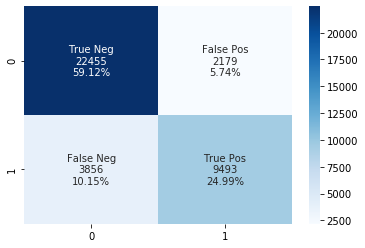

In [242]:
PlotConfusionMatrix(test_y, pred_y)

In [243]:
model_cancer_drop.evaluate(test_generator)

39/39 [==============================] - 0s 11ms/step - loss: 0.3527 - categorical_accuracy: 0.8447


[0.35265684127807617, 0.8447000980377197]

In [244]:
(test_y, pred_y) = PredictModel(model_cancer_drop)

In [245]:
ShowStats('base_drop', test_y, pred_y)

Accuracy score:  0.8446936787510202
F1 score:  0.8311647601583474
              precision    recall  f1-score   support

           0       0.89      0.87      0.88     24629
           1       0.77      0.80      0.78     13354

    accuracy                           0.84     37983
   macro avg       0.83      0.83      0.83     37983
weighted avg       0.85      0.84      0.85     37983



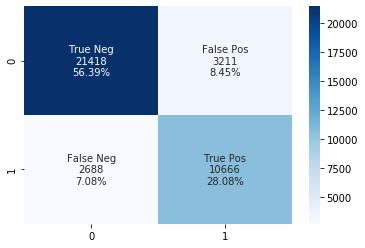

In [246]:
PlotConfusionMatrix(test_y, pred_y)

In [247]:
model_cancer_CV.evaluate(test_generator)

39/39 [==============================] - 0s 11ms/step - loss: 9.9109 - categorical_accuracy: 0.8316


[9.910943984985352, 0.8315529823303223]

In [248]:
(test_y, pred_y) = PredictModel(model_cancer_CV)

In [249]:
ShowStats('base_CV', test_y, pred_y)

Accuracy score:  0.8318194981965616
F1 score:  0.8206294924055584
              precision    recall  f1-score   support

           0       0.90      0.83      0.87     24627
           1       0.73      0.83      0.78     13356

    accuracy                           0.83     37983
   macro avg       0.81      0.83      0.82     37983
weighted avg       0.84      0.83      0.83     37983



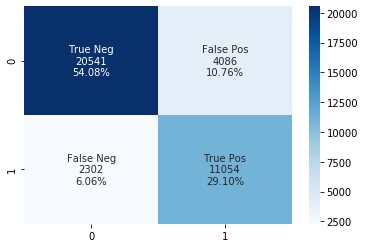

In [250]:
PlotConfusionMatrix(test_y, pred_y)

### Observation

* All of the NN model suffer from overfitting even though the accuracy scorce is not so bad
* Cross validation does nothing for the base model, and since it took along of time to complete it will not be used for the future models

# 2) CNN model (using leNet)
Next we will experiment using CNN models, in this section we will attempt to create a CNN model using leNet

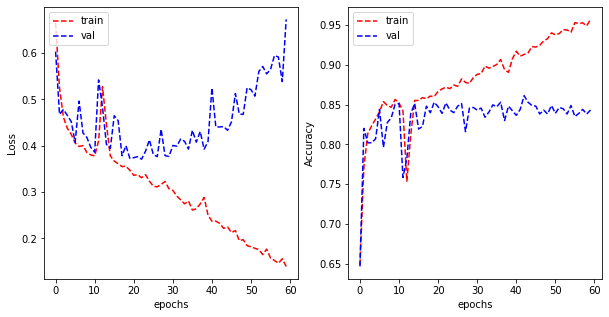

In [251]:
reg_lambda = 0.001
OUTPUT_CLASSES = 2

model_cancer_leNet1 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cancer_leNet1.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history_cancer_leNet1 = model_cancer_leNet1.fit(train_generator, 
                                    validation_data = validation_generator, 
                                    epochs=60, verbose=0)

plot_learning_curve(history_cancer_leNet1.history['loss'], history_cancer_leNet1.history['val_loss'], 
                    history_cancer_leNet1.history['categorical_accuracy'], history_cancer_leNet1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

Observation:

### Data augmentation

In [254]:
train_datagen_data_aug = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                  rotation_range=15, width_shift_range=0.2,
                                  height_shift_range=0.2)
train_datagen_data_aug2 = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                  rotation_range=10, width_shift_range=0.4,
                                  height_shift_range=0.4)
train_datagen_data_aug3 = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                  rotation_range=20, width_shift_range=0.6,
                                  height_shift_range=0.6)
train_datagen_data_aug4 = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                  rotation_range=40, width_shift_range=0.6,
                                  height_shift_range=0.6)

batch_size = 32

train_generator_data_aug = train_datagen_data_aug.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

train_generator_data_aug2 = train_datagen_data_aug2.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical',
        horizontal_flip=True)

train_generator_data_aug3 = train_datagen_data_aug3.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical',
        horizontal_flip=True)

train_generator_data_aug4 = train_datagen_data_aug4.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical',
        horizontal_flip=True)


Found 3651 validated image filenames belonging to 2 classes.
Found 3651 validated image filenames belonging to 2 classes.
Found 3651 validated image filenames belonging to 2 classes.
Found 3651 validated image filenames belonging to 2 classes.


The first attemp of data augmentation does not have horizontal flip. It will be in the control group. The other attemp will see more rotational, witdh and height shift as well as horizontal_flip

In [255]:
model_cancer_leNet2 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

model_cancer_leNet2.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history_cancer_leNet2 = model_cancer_leNet2.fit_generator(train_generator_data_aug, 
                                    validation_data = validation_generator, 
                                    epochs=60, verbose=0)

plot_learning_curve(history_cancer_leNet2.history['loss'], history_cancer_leNet2.history['val_loss'], 
                    history_cancer_leNet2.history['categorical_accuracy'], history_cancer_leNet2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### Attempt 2 

C:\Users\PC\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


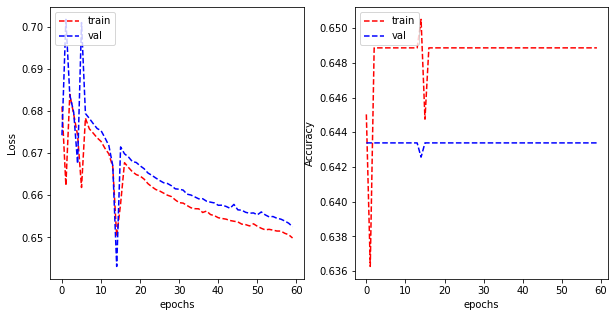

In [256]:
model_cancer_leNet3 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

model_cancer_leNet3.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history_cancer_leNet3 = model_cancer_leNet3.fit_generator(train_generator_data_aug2, 
                                    validation_data = validation_generator, 
                                    epochs=60, verbose=0)

plot_learning_curve(history_cancer_leNet3.history['loss'], history_cancer_leNet3.history['val_loss'], 
                    history_cancer_leNet3.history['categorical_accuracy'], history_cancer_leNet3.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### Attempt 3

In [257]:
model_cancer_leNet4 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

model_cancer_leNet4.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history_cancer_leNet4 = model_cancer_leNet4.fit_generator(train_generator_data_aug3, 
                                    validation_data = validation_generator, 
                                    epochs=60, verbose=0)

plot_learning_curve(history_cancer_leNet4.history['loss'], history_cancer_leNet4.history['val_loss'], 
                    history_cancer_leNet4.history['categorical_accuracy'], history_cancer_leNet4.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

C:\Users\PC\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


### Attempt 4

In [258]:
model_cancer_leNet5 = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(27, 27, 3)),
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Conv2D(32, (3, 3), kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Activation('relu'),
    
    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(reg_lambda))
])

model_cancer_leNet5.compile(optimizer=sgd,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['categorical_accuracy'])

history_cancer_leNet5 = model_cancer_leNet5.fit_generator(train_generator_data_aug4, 
                                    validation_data = validation_generator, 
                                    epochs=60, verbose=0)

plot_learning_curve(history_cancer_leNet5.history['loss'], history_cancer_leNet5.history['val_loss'], 
                    history_cancer_leNet5.history['categorical_accuracy'], history_cancer_leNet5.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

C:\Users\PC\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


## Testing the final model

In [259]:
model_cancer_leNet1.evaluate(test_generator)

39/39 [==============================] - 1s 13ms/step - loss: 0.5161 - categorical_accuracy: 0.8809


[0.5160687565803528, 0.8808545470237732]

In [260]:
(test_y, pred_y) = PredictModel(model_cancer_leNet1)

In [261]:
ShowStats('base leNet', test_y, pred_y)

Accuracy score:  0.8807704468802698
F1 score:  0.8681802307676951
              precision    recall  f1-score   support

           0       0.90      0.92      0.91     24606
           1       0.84      0.81      0.83     13346

    accuracy                           0.88     37952
   macro avg       0.87      0.87      0.87     37952
weighted avg       0.88      0.88      0.88     37952



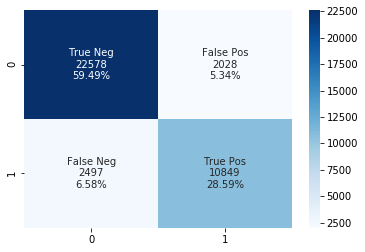

In [262]:
PlotConfusionMatrix(test_y, pred_y)

In [263]:
model_cancer_leNet2.evaluate(test_generator)

39/39 [==============================] - 0s 12ms/step - loss: 0.3488 - categorical_accuracy: 0.8628


[0.34875935316085815, 0.8627772927284241]

In [264]:
(test_y, pred_y) = PredictModel(model_cancer_leNet2)

In [265]:
ShowStats('leNet with data augmented attemp 1', test_y, pred_y)

Accuracy score:  0.8629386830950688
F1 score:  0.8371421462601321
              precision    recall  f1-score   support

           0       0.84      0.97      0.90     24632
           1       0.93      0.66      0.77     13351

    accuracy                           0.86     37983
   macro avg       0.88      0.82      0.84     37983
weighted avg       0.87      0.86      0.86     37983



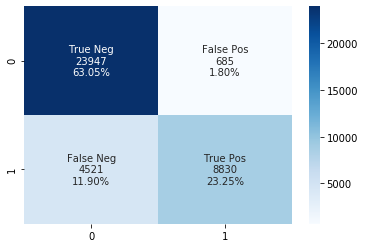

In [266]:
PlotConfusionMatrix(test_y, pred_y)

In [267]:
model_cancer_leNet3.evaluate(test_generator)

39/39 [==============================] - 0s 12ms/step - loss: 0.6490 - categorical_accuracy: 0.6483


[0.6489932537078857, 0.6483155488967896]

In [268]:
(test_y, pred_y) = PredictModel(model_cancer_leNet3)

In [269]:
ShowStats('leNet with data augmented attemp 2', test_y, pred_y)

Accuracy score:  0.648500645025406
F1 score:  0.39338816577497404
              precision    recall  f1-score   support

           0       0.65      1.00      0.79     24632
           1       0.00      0.00      0.00     13351

    accuracy                           0.65     37983
   macro avg       0.32      0.50      0.39     37983
weighted avg       0.42      0.65      0.51     37983



In [270]:
PlotConfusionMatrix(test_y, pred_y)

In [271]:
model_cancer_leNet4.evaluate(test_generator)

39/39 [==============================] - 0s 12ms/step - loss: 0.4056 - categorical_accuracy: 0.8496


[0.40563419461250305, 0.8496302366256714]

In [272]:
(test_y, pred_y) = PredictModel(model_cancer_leNet4)

In [273]:
ShowStats('leNet with data augmented attemp 3', test_y, pred_y)

Accuracy score:  0.849827554432246
F1 score:  0.8396641196363694
              precision    recall  f1-score   support

           0       0.91      0.85      0.88     24641
           1       0.75      0.85      0.80     13342

    accuracy                           0.85     37983
   macro avg       0.83      0.85      0.84     37983
weighted avg       0.86      0.85      0.85     37983



In [274]:
PlotConfusionMatrix(test_y, pred_y)

In [275]:
model_cancer_leNet5.evaluate(test_generator)

39/39 [==============================] - 0s 12ms/step - loss: 0.3724 - categorical_accuracy: 0.8554


[0.3724210858345032, 0.8553820848464966]

In [276]:
(test_y, pred_y) = PredictModel(model_cancer_leNet5)

In [277]:
ShowStats('leNet with data augmented attemp 4', test_y, pred_y)

Accuracy score:  0.8556986020061607
F1 score:  0.8313508630752585
              precision    recall  f1-score   support

           0       0.84      0.95      0.90     24614
           1       0.89      0.68      0.77     13369

    accuracy                           0.86     37983
   macro avg       0.87      0.81      0.83     37983
weighted avg       0.86      0.86      0.85     37983



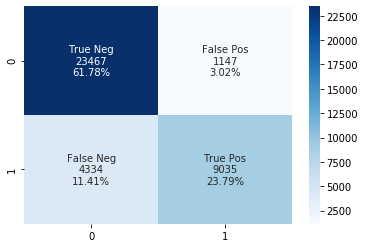

In [278]:
PlotConfusionMatrix(test_y, pred_y)

### Observation

   *  Model leNet 5, leNet 1 and 2 appear to have better loss/accuracy compare to the rest. However leNet1 appear to be underfit as the epochs increase, while leNet5 diverge and fit perfectly
   *  Model leNet 3-5 see increase in accuracy and fit as the rotation, witdh and height shift increase, with model 5 being the best out of them
   *  Model leNet 3 seem incapable of predicting isCancerous image, don't know what is the reason.
 
    
For all these reason, the data augmentation method for leNet 5 will be used for VGG
    

# 3) CNN model (using VGG)
Next we will experiment using CNN VGG models.

In [280]:
OUTPUT_CLASSES = 2
model_cancer_VGG_1 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

model_cancer_VGG_1.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history_cancer_VGG_1 = model_cancer_VGG_1.fit(train_generator, validation_data = validation_generator, epochs=60, verbose=0)

plot_learning_curve(history_cancer_VGG_1.history['loss'], history_cancer_VGG_1.history['val_loss'], 
                    history_cancer_VGG_1.history['categorical_accuracy'], history_cancer_VGG_1.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

### Data augmentation

In [287]:
train_datagen_data_aug_VGG = ImageDataGenerator(rescale=1./255, data_format='channels_last',
                                  rotation_range=40, width_shift_range=0.6,
                                  height_shift_range=0.6)
batch_size = 32

train_generator_data_aug_VGG = train_datagen_data_aug_VGG.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical',
        horizontal_flip=True)

Found 3651 validated image filenames belonging to 2 classes.


In [288]:
OUTPUT_CLASSES = 2
model_cancer_VGG_2 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

model_cancer_VGG_2.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history_cancer_VGG_2 = model_cancer_VGG_2.fit(train_generator_data_aug_VGG, validation_data = validation_generator, epochs=60, verbose=0)

plot_learning_curve(history_cancer_VGG_2.history['loss'], history_cancer_VGG_2.history['val_loss'], 
                    history_cancer_VGG_2.history['categorical_accuracy'], history_cancer_VGG_2.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Adding regularization and dropout

In [303]:
reg_lambda = 0.001
OUTPUT_CLASSES = 2
model_cancer_VGG_3 = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda), input_shape=(27, 27, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 2
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    #VGG block 3
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same', 
                           kernel_regularizer=tf.keras.regularizers.l2(reg_lambda)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

model_cancer_VGG_3.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

history_cancer_VGG_3 = model_cancer_VGG_3.fit(train_generator, validation_data = validation_generator, epochs = 60, verbose=0)

plot_learning_curve(history_cancer_VGG_3.history['loss'], history_cancer_VGG_3.history['val_loss'], 
                    history_cancer_VGG_3.history['categorical_accuracy'], history_cancer_VGG_3.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

## Testing the final model

In [332]:
model_cancer_VGG_1.evaluate(test_generator)

39/39 [==============================] - 1s 18ms/step - loss: 1.4497 - categorical_accuracy: 0.8603


[1.449726939201355, 0.8603122234344482]

In [333]:
(test_y, pred_y) = PredictModel(model_cancer_VGG_1)


In [334]:
ShowStats('VGG_Baseline', test_y, pred_y)

Accuracy score:  0.8601742884974857
F1 score:  0.8455881075601331
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     24636
           1       0.81      0.79      0.80     13347

    accuracy                           0.86     37983
   macro avg       0.85      0.84      0.85     37983
weighted avg       0.86      0.86      0.86     37983



In [335]:
PlotConfusionMatrix(test_y, pred_y)

In [336]:
model_cancer_VGG_2.evaluate(test_generator)

39/39 [==============================] - 1s 17ms/step - loss: 0.2665 - categorical_accuracy: 0.8973


[0.266509473323822, 0.89728844165802]

In [337]:
(test_y, pred_y) = PredictModel(model_cancer_VGG_2)

In [338]:
ShowStats('VGG_Baseline with data augmented', test_y, pred_y)

Accuracy score:  0.8977173998894242
F1 score:  0.8833209189860207
              precision    recall  f1-score   support

           0       0.89      0.96      0.92     24622
           1       0.92      0.78      0.84     13361

    accuracy                           0.90     37983
   macro avg       0.90      0.87      0.88     37983
weighted avg       0.90      0.90      0.90     37983



In [339]:
PlotConfusionMatrix(test_y, pred_y)

In [340]:
model_cancer_VGG_3.evaluate(test_generator)

39/39 [==============================] - 1s 16ms/step - loss: 0.7691 - categorical_accuracy: 0.8422


[0.7690902352333069, 0.8422350287437439]

In [341]:
(test_y, pred_y) = PredictModel(model_cancer_VGG_3)

In [342]:
ShowStats('VGG_Baseline with and dropout and regulisation', test_y, pred_y)

Accuracy score:  0.841902956585841
F1 score:  0.8314664470210591
              precision    recall  f1-score   support

           0       0.91      0.84      0.87     24625
           1       0.74      0.84      0.79     13358

    accuracy                           0.84     37983
   macro avg       0.83      0.84      0.83     37983
weighted avg       0.85      0.84      0.84     37983



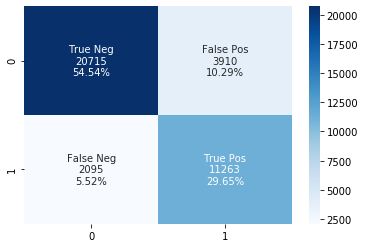

In [343]:
PlotConfusionMatrix(test_y, pred_y)

### Observation

  * VGG with data augmented seem to have better than the other 2 model
  * Again regulisation and drop out show no performace increase when applied

# Model comparison and ultimate judegment


In [344]:
print("{:20} {:>10} {:>10} {:>10} {:>10}".format('Name', 'Accuracy', 'F1-score', 'Precision', 'Recall'))
for mr in modelResults:
    print("{:20} {:10.2f} {:10.2f} {:10.2f} {:10.2f}".format(mr.name, mr.accuracy, mr.f1, mr.precision, mr.recall))

Name                   Accuracy   F1-score  Precision     Recall
base model                 0.86       0.84       0.80       0.79
base_regulisation          0.84       0.82       0.81       0.71
base_drop                  0.84       0.83       0.77       0.80
base_CV                    0.83       0.82       0.73       0.83
base leNet                 0.88       0.87       0.84       0.81
leNet with data augmented attemp 1       0.86       0.84       0.93       0.66
leNet with data augmented attemp 2       0.65       0.39       0.00       0.00
leNet with data augmented attemp 3       0.85       0.84       0.75       0.85
leNet with data augmented attemp 4       0.86       0.83       0.89       0.68
VGG_Baseline               0.86       0.85       0.81       0.79
VGG_Baseline with data augmented       0.90       0.88       0.92       0.78
VGG_Baseline with and dropout and regulisation       0.84       0.83       0.74       0.84


### Analysis of model

looking at the model as the screening tool for Cancer dectection:
   * All the base NN model seem to over overfit
   * Applying dropout and regulisation seem to make the problem above worse not better
   * Data augmentation seem to be a better choice than dropout and regulisation for both time and performace.
   * VGG model with data augmented have the best accuracy score and fit better than the rest of these model
Final judegment: 
    VGG_Baselinewith data augmented will be the screening tool